In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
%matplotlib inline

In [2]:
full_df_NO = pd.read_pickle("full_df_2021_NOX.pkl")
pd.set_option('display.max_columns', None)

## This the data cleaning. Keeping only the relevant features and removing the less than equal to zero target values

df1= full_df_NO.drop(full_df_NO.columns[[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1)
df2 = df1.drop(df1.columns[[2,3,4,5,6,9]], axis=1) 
j=[]
for i in range(4,72):
    j.append(i)
df3 = df2.drop(df2.columns[j], axis=1) 
df4 = df3.drop(df3.columns[[11,12,13,14,15,16,17,18]], axis=1) 
df4 = df4.drop(df3.columns[[6]], axis=1) 
df4.rename(columns={'NO': 'NO (ppb)','pda': 'Average Pupil Diameter (mm)', 'pup_dis': 'Pupil Distance (mm)','pd_diff': 'Difference in Pupil Diameter (mm)', 'ECG.': 'ECG (V)','Resp.': 'Respiration Rate (brpm)','Temp.': 'Skin Temperature ($\mathrm{^o C})$','HR': 'Heart Rate (bpm)','SpO2':'$\mathrm{SpO_2}$ (%)','GSR':'GSR ($\mathrm{\mu S}$)'}, inplace=True)

df_final = df4[df4['NO (ppb)'] >0]

## Lets change some of variables to standard units

pd.options.mode.chained_assignment = None ## apparently this needs to be added to overcome an error i dont understand  

df_final['$\mathrm{SpO_2}$ (%)']=df_final['$\mathrm{SpO_2}$ (%)']*1000000 ## change the SpO2 to percentage
df_final['GSR ($\mathrm{\mu S}$)']=df_final['GSR ($\mathrm{\mu S}$)']*1000 ## convert kiloohms to ohms
df_final['GSR ($\mathrm{\mu S}$)']=1/df_final['GSR ($\mathrm{\mu S}$)']  ## convert ohms to siemans by taking the reciprocal
df_final['GSR ($\mathrm{\mu S}$)']=df_final['GSR ($\mathrm{\mu S}$)']*1000000 ## convert siemens to microsiemens
df_final

,NO (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$,Fp1-delta ($\mathrm{V^2}$/Hz),Fp2-delta ($\mathrm{V^2}$/Hz),F3-delta ($\mathrm{V^2}$/Hz),F4-delta ($\mathrm{V^2}$/Hz),C3-delta ($\mathrm{V^2}$/Hz),C4-delta ($\mathrm{V^2}$/Hz),P3-delta ($\mathrm{V^2}$/Hz),P4-delta ($\mathrm{V^2}$/Hz),O1-delta ($\mathrm{V^2}$/Hz),O2-delta ($\mathrm{V^2}$/Hz),F7-delta ($\mathrm{V^2}$/Hz),F8-delta ($\mathrm{V^2}$/Hz),T7-delta ($\mathrm{V^2}$/Hz),T8-delta ($\mathrm{V^2}$/Hz),P7-delta ($\mathrm{V^2}$/Hz),P8-delta ($\mathrm{V^2}$/Hz),Fz-delta ($\mathrm{V^2}$/Hz),Cz-delta ($\mathrm{V^2}$/Hz),Pz-delta ($\mathrm{V^2}$/Hz),Oz-delta ($\mathrm{V^2}$/Hz),FC1-delta ($\mathrm{V^2}$/Hz),FC2-delta ($\mathrm{V^2}$/Hz),CP1-delta ($\mathrm{V^2}$/Hz),CP2-delta ($\mathrm{V^2}$/Hz),FC5-delta ($\mathrm{V^2}$/Hz),FC6-delta ($\mathrm{V^2}$/Hz),CP5-delta ($\mathrm{V^2}$/Hz),CP6-delta ($\mathrm{V^2}$/Hz),FT9-delta ($\mathrm{V^2}$/Hz),FT10-delta ($\mathrm{V^2}$/Hz),FCz-delta ($\mathrm{V^2}$/Hz),AFz-delta ($\mathrm{V^2}$/Hz),F1-delta ($\mathrm{V^2}$/Hz),F2-delta ($\mathrm{V^2}$/Hz),C1-delta ($\mathrm{V^2}$/Hz),C2-delta ($\mathrm{V^2}$/Hz),P1-delta ($\mathrm{V^2}$/Hz),P2-delta ($\mathrm{V^2}$/Hz),AF3-delta ($\mathrm{V^2}$/Hz),AF4-delta ($\mathrm{V^2}$/Hz),FC3-delta ($\mathrm{V^2}$/Hz),FC4-delta ($\mathrm{V^2}$/Hz),CP3-delta ($\mathrm{V^2}$/Hz),CP4-delta ($\mathrm{V^2}$/Hz),PO3-delta ($\mathrm{V^2}$/Hz),PO4-delta ($\mathrm{V^2}$/Hz),F5-delta ($\mathrm{V^2}$/Hz),F6-delta ($\mathrm{V^2}$/Hz),C5-delta ($\mathrm{V^2}$/Hz),C6-delta ($\mathrm{V^2}$/Hz),P5-delta ($\mathrm{V^2}$/Hz),P6-delta ($\mathrm{V^2}$/Hz),AF7-delta ($\mathrm{V^2}$/Hz),AF8-delta ($\mathrm{V^2}$/Hz),FT7-delta ($\mathrm{V^2}$/Hz),FT8-delta ($\mathrm{V^2}$/Hz),TP7-delta ($\mathrm{V^2}$/Hz),TP8-delta ($\mathrm{V^2}$/Hz),PO7-delta ($\mathrm{V^2}$/Hz),PO8-delta ($\mathrm{V^2}$/Hz),Fpz-delta ($\mathrm{V^2}$/Hz),CPz-delta ($\mathrm{V^2}$/Hz),POz-delta ($\mathrm{V^2}$/Hz),TP10-delta ($\mathrm{V^2}$/Hz),Fp1-theta ($\mathrm{V^2}$/Hz),Fp2-theta ($\mathrm{V^2}$/Hz),F3-theta ($\mathrm{V^2}$/Hz),F4-theta ($\mathrm{V^2}$/Hz),C3-theta ($\mathrm{V^2}$/Hz),C4-theta ($\mathrm{V^2}$/Hz),P3-theta ($\mathrm{V^2}$/Hz),P4-theta ($\mathrm{V^2}$/Hz),O1-theta ($\mathrm{V^2}$/Hz),O2-theta ($\mathrm{V^2}$/Hz),F7-theta ($\mathrm{V^2}$/Hz),F8-theta ($\mathrm{V^2}$/Hz),T7-theta ($\mathrm{V^2}$/Hz),T8-theta ($\mathrm{V^2}$/Hz),P7-theta ($\mathrm{V^2}$/Hz),P8-theta ($\mathrm{V^2}$/Hz),Fz-theta ($\mathrm{V^2}$/Hz),Cz-theta ($\mathrm{V^2}$/Hz),Pz-theta ($\mathrm{V^2}$/Hz),Oz-theta ($\mathrm{V^2}$/Hz),FC1-theta ($\mathrm{V^2}$/Hz),FC2-theta ($\mathrm{V^2}$/Hz),CP1-theta ($\mathrm{V^2}$/Hz),CP2-theta ($\mathrm{V^2}$/Hz),FC5-theta ($\mathrm{V^2}$/Hz),FC6-theta ($\mathrm{V^2}$/Hz),CP5-theta ($\mathrm{V^2}$/Hz),CP6-theta ($\mathrm{V^2}$/Hz),FT9-theta ($\mathrm{V^2}$/Hz),FT10-theta ($\mathrm{V^2}$/Hz),FCz-theta ($\mathrm{V^2}$/Hz),AFz-theta ($\mathrm{V^2}$/Hz),F1-theta ($\mathrm{V^2}$/Hz),F2-theta ($\mathrm{V^2}$/Hz),C1-theta ($\mathrm{V^2}$/Hz),C2-theta ($\mathrm{V^2}$/Hz),P1-theta ($\mathrm{V^2}$/Hz),P2-theta ($\mathrm{V^2}$/Hz),AF3-theta ($\mathrm{V^2}$/Hz),AF4-theta ($\mathrm{V^2}$/Hz),FC3-theta ($\mathrm{V^2}$/Hz),FC4-theta ($\mathrm{V^2}$/Hz),CP3-theta ($\mathrm{V^2}$/Hz),CP4-theta ($\mathrm{V^2}$/Hz),PO3-theta ($\mathrm{V^2}$/Hz),PO4-theta ($\mathrm{V^2}$/Hz),F5-theta ($\mathrm{V^2}$/Hz),F6-theta ($\mathrm{V^2}$/Hz),C5-theta ($\mathrm{V^2}$/Hz),C6-theta ($\mathrm{V^2}$/Hz),P5-theta ($\mathrm{V^2}$/Hz),P6-theta ($\mathrm{V^2}$/Hz),AF7-theta ($\mathrm{V^2}$/Hz),AF8-theta ($\mathrm{V^2}$/Hz),FT7-theta ($\mathrm{V^2}$/Hz),FT8-theta ($\mathrm{V^2}$/Hz),TP7-theta ($\mathrm{V^2}$/Hz),TP8-theta ($\mathrm{V^2}$/Hz),PO7-theta ($\mathrm{V^2}$/Hz),PO8-theta ($\mathrm{V^2}$/Hz),Fpz-theta ($\mathrm{V^2}$/Hz),CPz-theta ($\mathrm{V^2}$/Hz),POz-theta ($\mathrm{V^2}$/Hz),TP10-theta ($\mathrm{V^2}$/

In [3]:
## Lets create a Train-Test set and transform the data.

features=df_final.drop("NO (ppb)",axis=1)
target=df_final["NO (ppb)"].copy()

#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

In [4]:
## Lets now train the model using Random Forest Regressor 

#from sklearn.ensemble import RandomForestRegressor
#import numpy as np
#from sklearn.metrics import mean_squared_error

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train,y_train)

## The train prediction
train_prediction_RF=forest_reg.predict(X_train)
RF_mse=mean_squared_error(y_train,train_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_train=RF_rmse

print('The train RMSE for NO is:::', '%.2f' % RF_rmse_train)

The train RMSE for NO is::: 4.77


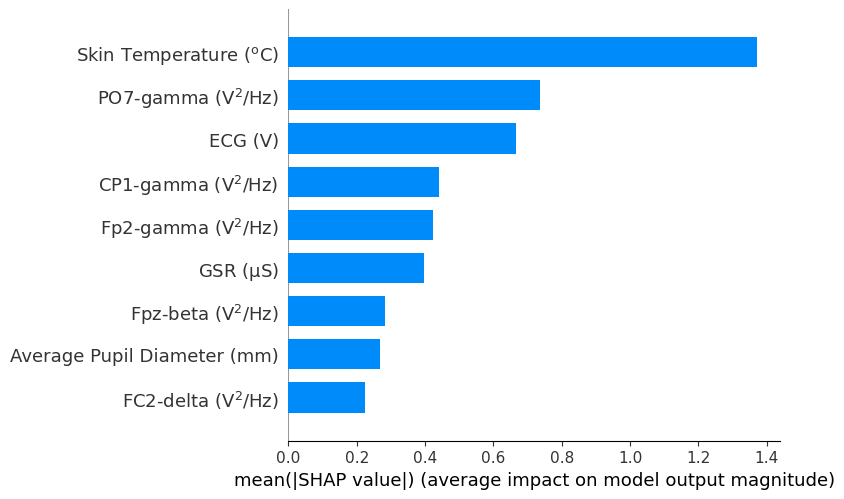

In [5]:
## Lets now use SHAP values for feature importance

import shap

shap_values = shap.TreeExplainer(forest_reg).shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=9)


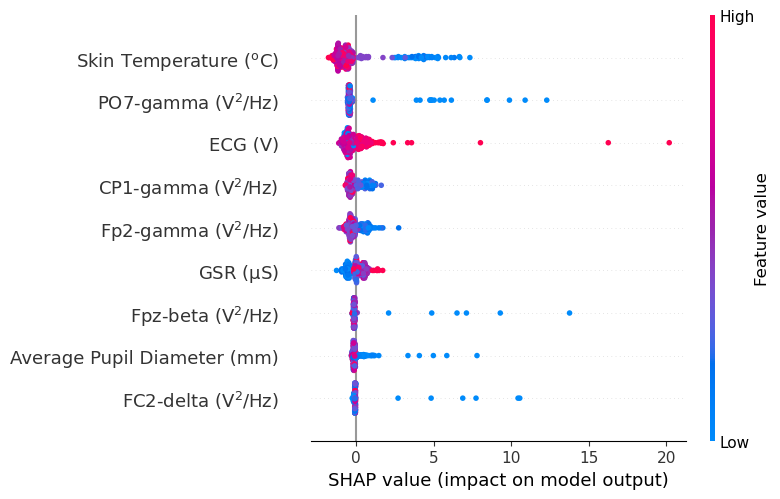

In [6]:
shap.summary_plot(shap_values, X_train,max_display=9)

Text(0.5, 1.0, "Pearson's Correlation Coefficient Plot")

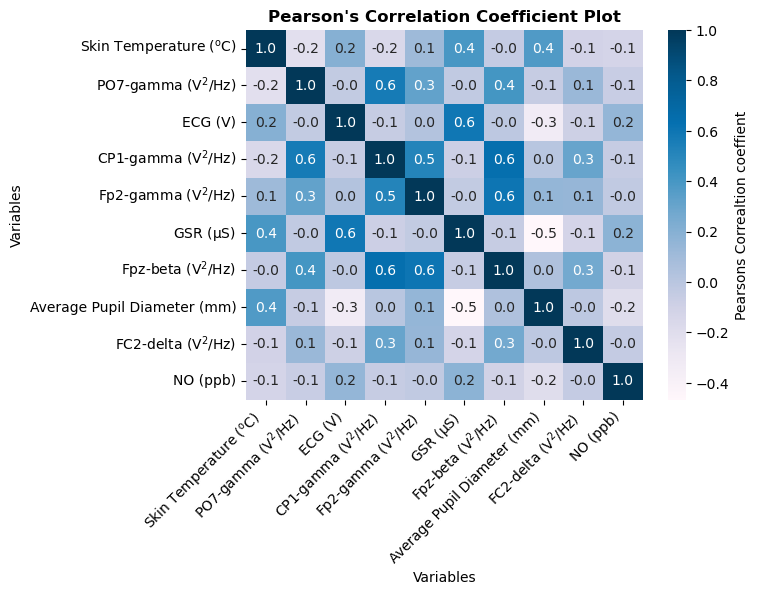

In [7]:
## lets get the top 9 features as selected by SHAP values
#import matplotlib.pyplot as plt

shap_names=X_train.columns[np.argsort(np.abs(shap_values).mean(0))]  ## gives entire names in ascending order

## lets reverse the list of the names
shap_descending=[]
for i in reversed(shap_names):
    shap_descending.append(i)

## lets get the top 9 features as selected by SHAP values
    
names_rev_shap=[]
for i in range(0,9):
    names_rev_shap.append(shap_descending[i])
    
## Now that we have the list of top 10 features, lets plot the correlation plot

names_rev_shap.append('NO (ppb)') ## add the target NO for the correlation matrix
corr=df_final[names_rev_shap].corr()

#import seaborn as sns
ax=sns.heatmap(corr,cmap="PuBu",annot=True,fmt=".1f",cbar_kws={'label': 'Pearsons Correaltion coeffient'})

plt.xticks(rotation=45,horizontalalignment='right')

ax.set(xlabel="Variables",ylabel="Variables")

plt.title("Pearson's Correlation Coefficient Plot",fontweight='bold')


Text(0.5, 1.0, 'Mutual Information Plot')

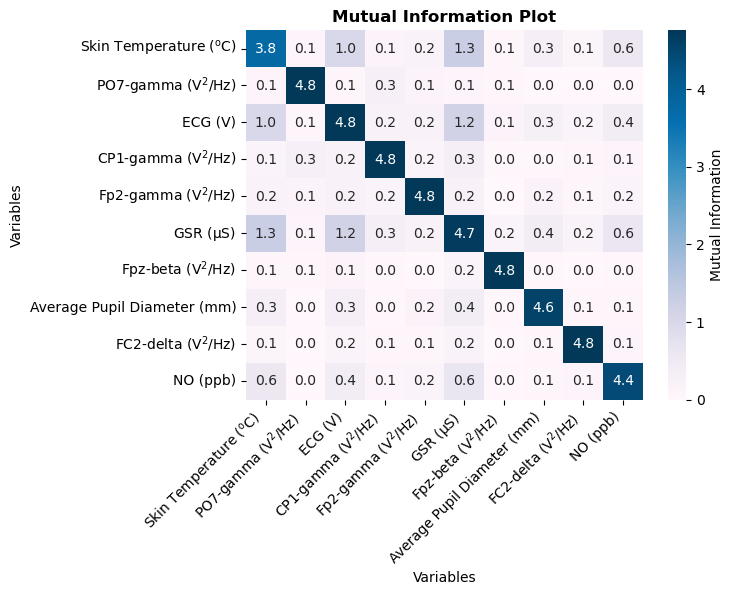

In [8]:
## Now lets plot the mutual information

#from sklearn.feature_selection import mutual_info_regression

## Lets calucalute the mutual information against each of the top 9 features

mf_mat=[]
for i in range(0,10):
    for j in range(0,10):
        dd=df_final[names_rev_shap[i]]
        mm=df_final[names_rev_shap[j]]

        kk=dd.to_numpy().reshape((-1,1))
        vv=mm.to_numpy().reshape((-1,1))
        pp=vv.reshape(410,)             ## reshape the array to (2317,) as required by the mutual_info_regression function

        mi=mutual_info_regression(kk,pp)
        mf_mat.append(mi)

mf_mat_arr=np.asarray(mf_mat)  ## transform the elements from a list to array

# reshape array into 10 rows x 10 columns

reshaped_array = mf_mat_arr.reshape(10, 10).T 

mf_df=pd.DataFrame(reshaped_array,columns=[names_rev_shap],index=[names_rev_shap]) ## convert into a pandas DataFrame

ax=sns.heatmap(mf_df,cmap="PuBu",annot=True,fmt='.1f',cbar_kws={'label':'Mutual Information'}) ## Now lets plot the mutual information heatmap

plt.xticks(rotation=45,horizontalalignment='right')

ax.set(title="Mutual Information Plot",xlabel="Variables",ylabel="Variables")

plt.title("Mutual Information Plot",fontweight='bold')

In [9]:
## The test prediction

test_prediction_RF=forest_reg.predict(X_test)
RF_mse=mean_squared_error(y_test,test_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_test=RF_rmse

print('The test RMSE for NO is:::', '%.2f' % RF_rmse_test)



The test RMSE for NO is::: 15.92


In [10]:
### The correlation values

#from scipy.stats import pearsonr

## The train correlation
train_r_sq=pearsonr(y_train,train_prediction_RF)[0]
correlation_train=int(train_r_sq*100)/100 ## display only two digits without rounding
print(correlation_train)

## The test correlation
test_r_sq=pearsonr(y_test,test_prediction_RF)[0]
correlation_test=int(test_r_sq*100)/100 ## display only two digits without rounding
print(correlation_test)

0.96
0.41


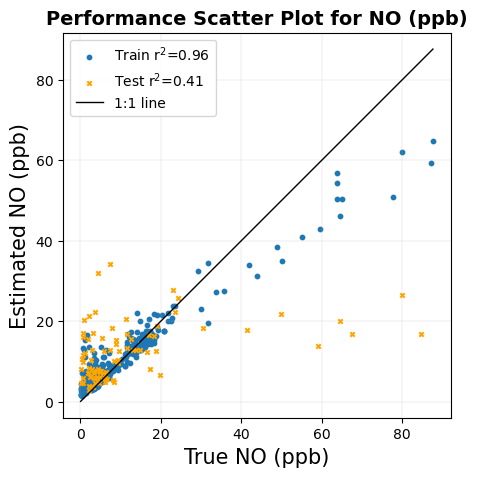

In [11]:
## Lets plot the scatter plot

import matplotlib as mpl
mpl.rcParams['mathtext.default']='regular'

plt.figure(figsize=(5,5))
plt.scatter(y_train, train_prediction_RF,s=10,c='C0',label='Train $r^2$={}'.format(correlation_train))
plt.scatter(y_test, test_prediction_RF,marker='x',s=10,c='orange',label='Test $r^2$={}'.format(correlation_test))


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))
plt.plot([p1, p2], [p1, p2], 'black',label='1:1 line',linewidth=1)
plt.xlabel('True NO (ppb)', fontsize=15)
plt.ylabel('Estimated NO (ppb)', fontsize=15)
plt.axis('equal')
plt.title("Performance Scatter Plot for NO (ppb)", fontsize=14,fontweight="bold")
plt.legend()
plt.grid(axis='both',linewidth=0.15)
plt.show()

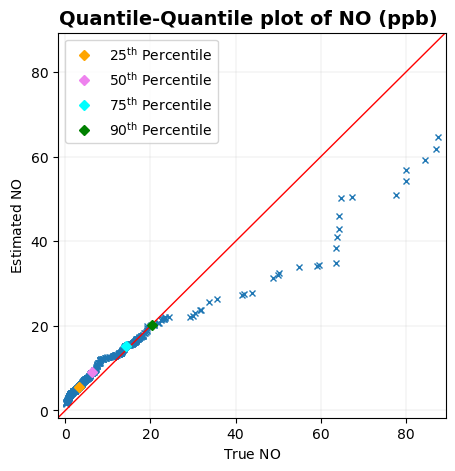

In [12]:
## Lets now plot the quantile quantile plot

import statsmodels.api as sm
import scipy.stats as stats

all_preds_NO=np.concatenate((train_prediction_RF,test_prediction_RF)) ## the list of all predictions and target values

preds=np.sort(all_preds_NO)
tars=target.sort_values()

plt.rc("figure", figsize=(5,5)) ## to make same figure size in statsmodels.api

pp_x = sm.ProbPlot(preds, fit=False)
pp_y = sm.ProbPlot(tars, fit=False)
qq = pp_x.qqplot(xlabel='True $\mathrm{NO}$',ylabel='Estimated $\mathrm{NO}$',marker='x',markersize=4,other=pp_y)

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1)
tars_25=np.percentile(tars,25)  ## for the percentiles                                                        
tars_50=np.percentile(tars,50)
tars_75=np.percentile(tars,75)
tars_90=np.percentile(tars,90)


preds_25=np.percentile(preds,25)
preds_50=np.percentile(preds,50)
preds_75=np.percentile(preds,75)  
preds_90=np.percentile(tars,90)  ## end of percentiles

plt.plot(tars_25,preds_25,marker="D",markersize=5,color="orange",linestyle ='None',label="$\mathrm{25^{th}}$ Percentile")
plt.plot(tars_50,preds_50,marker="D",markersize=5,color="violet",linestyle ='None',label="$\mathrm{50^{th}}$ Percentile")
plt.plot(tars_75,preds_75,marker="D",markersize=5,color="Cyan",linestyle ='None',label="$\mathrm{75^{th}}$ Percentile")
plt.plot(tars_90,preds_90,marker="D",markersize=5,color="Green",linestyle ='None',label="$\mathrm{90^{th}}$ Percentile")


plt.grid(axis='both',linewidth=0.15)

plt. title('Quantile-Quantile plot of NO (ppb) ',fontsize=14,fontweight="bold")

plt.legend()
plt.show()


## Note that since the number of samples is the same, sorting the values in ascending or descending order and then...
## plotting a scatter plot will also do the same thing as the quantiles are located in same point for distribution..
## of same size.


In [13]:
## Lets now plot the Time series for NO

splitted_original_data=pd.concat([y_train,y_test]) ## concatenate the splitted original target variable i.e. NO
splitted_original_data

predicted_splited=np.concatenate((train_prediction_RF,test_prediction_RF),axis=None) ## concatenate the predicted....
predicted_splited                                                                    ## train and test numpy arrays

splitted_df=splitted_original_data.to_frame() ##convert splitted original data NO2 from pandas series to 
splitted_df                                       ## pandas dataframe

splitted_df['predicted_splited']=predicted_splited.tolist() ## Now concatenate the NO dataframe and the
splitted_df                                                        ## the numpy array

sorted_df=splitted_df.sort_values(by='dateTime') ## sort according to timestamp
sorted_df  

df_reset=sorted_df.reset_index() ##reset the index and start from zero as the hh:mm:ss is not real time
df_reset 

df_indexed=df_reset.drop(columns="dateTime") 
df_indexed 

df_timeseries=df_indexed.rename(columns={'NO':'True NO','predicted_splited':'Estimated NO'})
df_timeseries

,NO (ppb),Estimated NO
0,0.1,3.278
1,0.8,5.796
2,1.4,2.727
3,2.1,3.129
4,3.6,3.508
...,...,...
405,35.7,27.506
406,43.9,31.340
407,6.8,7.822
408,4.4,8.183


In [14]:
## lets now extract rows from the timeseries so that there is discontinuity in the trials, as the red lines seen are...
## continous

timeseries_1=df_timeseries.iloc[0:80,:]
timeseries_2=df_timeseries.iloc[81:95,:]
timeseries_3=df_timeseries.iloc[96:191,:]
timeseries_4=df_timeseries.iloc[192:279,:]
timeseries_5=df_timeseries.iloc[280:377,:]
timeseries_6=df_timeseries.iloc[378:409,:]

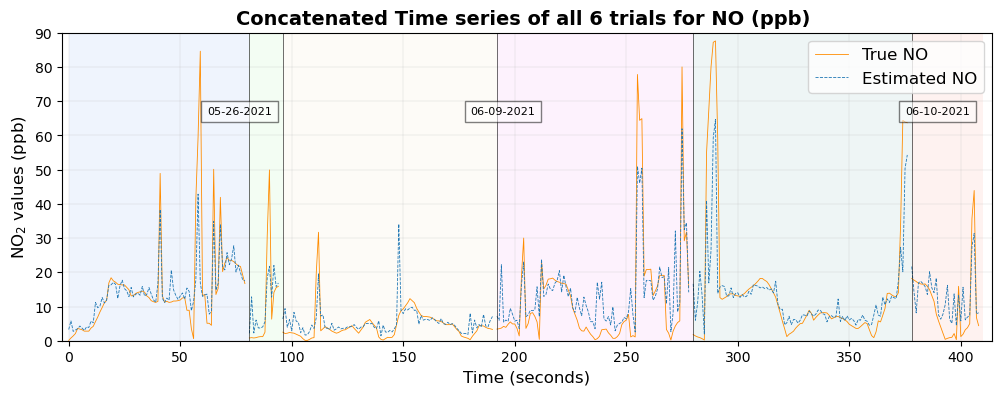

In [15]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(timeseries_1['NO (ppb)'],label='True NO',linewidth=0.6,color='darkorange')
ax.plot(timeseries_1['Estimated NO'],label='Estimated NO',linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_2['NO (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_2['Estimated NO'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_3['NO (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_3['Estimated NO'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_4['NO (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_4['Estimated NO'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_5['NO (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_5['Estimated NO'],linewidth=0.6,linestyle='--',color='C0')

ax.plot(timeseries_6['NO (ppb)'],linewidth=0.6,color='darkorange')
ax.plot(timeseries_6['Estimated NO'],linewidth=0.6,linestyle='--',color='C0')


plt.text(62,66, '05-26-2021', fontsize = 8, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

plt.text(180,66, '06-09-2021', fontsize = 8, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

plt.text(375,66, '06-10-2021', fontsize = 8, 
         bbox = dict(facecolor = 'white', alpha = 0.5))


rect1 = patches.Rectangle((0, 0), 81, 94, fc="CornflowerBlue",alpha=0.1)
ax.add_patch(rect1)

rect2 = patches.Rectangle((81, 0), 15, 94, fc="lightgreen",alpha=0.1)
ax.add_patch(rect2)

rect3 = patches.Rectangle((96, 0), 96, 94, fc="wheat",alpha=0.1)
ax.add_patch(rect3)

rect4 = patches.Rectangle((192, 0), 88, 94, fc="violet",alpha=0.1)
ax.add_patch(rect4)

rect5 = patches.Rectangle((280, 0),98, 94, fc="cadetblue",alpha=0.1)
ax.add_patch(rect5)

rect6 = patches.Rectangle((378, 0),32, 94, fc="salmon",alpha=0.1)
ax.add_patch(rect6)

plt.xlim([-3,414])
plt.ylim([0,90])

plt.axvline(x=81, color='k', linewidth=0.4)
plt.axvline(x=96, color='k', linewidth=0.4)
plt.axvline(x=192, color='k', linewidth=0.4)
plt.axvline(x=280, color='k', linewidth=0.4)
plt.axvline(x=378, color='k', linewidth=0.4)

plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('$\mathrm{NO_2}$ values (ppb)',fontsize=12)
plt.title('Concatenated Time series of all 6 trials for NO (ppb) ',fontsize=14,fontweight="bold")
plt.legend(fontsize=12)
plt.grid(axis='both',linewidth=0.15)
plt.show()

In [16]:
## lets calculate the average values RMSE
from statistics import mean
j_train=[]
j_test=[]
k_train=[]
k_test=[]
for i in range(0,5):
    
    
    
    X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)
    forest_reg=RandomForestRegressor()
    forest_reg.fit(X_train,y_train)

    train_prediction=forest_reg.predict(X_train)
    mse_train=mean_squared_error(y_train,train_prediction)
    rmse_train=np.sqrt(mse_train)
    j_train.append(rmse_train)
    
    test_prediction=forest_reg.predict(X_test)

    mse_test=mean_squared_error(y_test,test_prediction)
    rmse_test=np.sqrt(mse_test)
    j_test.append(rmse_test)

## lets calculate the average correlation    
  
    train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
    correlation_train=int(train_r_sq*100)/100 ## display 
    k_train.append(correlation_train)
    
    test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
    correlation_test=int(test_r_sq*100)/100
    k_test.append(correlation_test)

average_train_rmse=mean(j_train)
average_test_rmse=mean(j_test)
    
average_train_rsq=mean(k_train)
average_test_rsq=mean(k_test)

print('The average train RMSE for NO is:::', '%.2f' % average_train_rmse)
print('The average test RMSE for NO is:::', '%.2f' % average_test_rmse)

print('The average train r square for NO is:::', '%.2f' % average_train_rsq)
print('The average test r square for NO is:::', '%.2f' % average_test_rsq)

The average train RMSE for NO is::: 5.07
The average test RMSE for NO is::: 14.75
The average train r square for NO is::: 0.93
The average test r square for NO is::: 0.19
